# Regression Modeling of Bitcoin with Stock-to-Flow

The pyfinlab stock_to_flow module contains methods for measuring the stock-to-flow ratio of a cryptocurrency and regressing it on market value. This work was inspired by the pseudo-anonymous Plan B's article "Modeling Bitcoin Value with Scarcity" (https://medium.com/@100trillionUSD/modeling-bitcoins-value-with-scarcity-91fa0fc03e25), where he hypothesizes that scarcity, as measured by stock-to-flow ratio, is an important factor in determining the price of Bitcoin. The purpose of this notebook is to measure Bitcoin's stock-to-flow ratio, regress it on market value, and test the assumptions underlying this model. I found a statistically significant regression model based on stock-to-flow, seemingly indicating, that stock-to-flow could be used to determine the price of Bitcoin. Unfortunately, there are some issues with this conclusion. First, the information value of stock-to-flow should already be priced into the market if we believe in efficient markets. Second, an augmented Engle-Granger two-step cointegration test (scroll down to the end) found no cointegration at the 5% significance level, essentially invalidating any regression model as spurious correlation. Heteroskedasticity and serial correlation were also detected but were corrected for The results of this stock-to-flow regression model, therefore, should not be relied upon but it is an interesting exercise in econometrics. 

The workflow below is as follows: 

1. Import stock-to-flow module. 
2. Download cryptocurrency data from Coin Metrics. 
3. Collect all cryptocurrency tickers and filter out those which do not have required data. 
4. Fit a regression model to the observed stock-to-flow data with market price as dependent variable. 
5. Conduct hypothesis test to determine whether regression model is statistically significant. 
6. Test for violations of the classic normal linear regression assumptions. 

In [1]:
from pyfinlab import stock_to_flow as sf

Download data updated daily by Coin Metrics from https://github.com/coinmetrics/data/tree/master/csv. Comment out if you already have today's data downloaded, otherwise, it will download data each time this cell is run and save to the coinmetrics folder within '../data/coinmetrics/' path. It takes about 2-3 minutes to complete downloading all the data.

In [2]:
sf.download()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [02:58<00:00,  1.68s/it]


Display tickers for which data is available for a stock-to-flow model and for which no Error or RuntimeWarning are thrown. Refer to https://docs.coinmetrics.io/asset-metrics/network-usage/blkcnt and https://docs.coinmetrics.io/asset-metrics/supply/splycur for more information on the required inputs. The method below searches all ticker data specifically for 'blkcnt' and 'splycur' and removes tickers which have no data. Finally, the method also tries to fit a power law model to the data and filters out tickers whose data causes the parameter optimization algorithm to throw a RuntimeWarning. Tickers which have data but throws a RuntimeWarning may contain data which cannot be properly fitted to a power law curve for whatever reasons, one of which is not having a large enough sample size. 

In [3]:
tickers = sf.clean_tickers()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.84it/s]

Tickers which ran without raising an Error or RuntimeWarning: ['bch', 'bsv', 'btc', 'btg', 'dash', 'dcr', 'dgb', 'doge', 'etc', 'eth', 'grin', 'icp', 'ltc', 'vtc', 'xmr', 'xtz', 'zec']
Number of Tickers: 17


The following methods should work with any ticker from the list above. Let's look at Bitcoin (btc).

## Power Law Model

$MarketCapUSD = e^{a} * SF^b$ and is equivalent to $ln(MarketCapUSD) = b * ln(SF) + a$ which is a linear function. So we can conduct a linear regression. 

The first term is the natural exponential function of coefficient a, which is multiplied by stock-to-flow (SF) to the power of coefficient b. The Spearman R-Squared is deemed statistically significant and different from 0 if the p-value is less than 0.05 at the 95% confidence level. The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Spearman correlation at least as extreme as the one computed from these datasets. The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so. In this example, the entire available data history is used as our in-sample. 

$H_{0}: \rho = 0$, correlation is not statistically significant. <br>
$H_{a}: \rho$ $\neq 0$, correlation is statistically significant. <br>

You can type any ticker from the ticker list above. Let's generate a stock-to-flow model for Bitcoin (ticker: btc), estimate a prediction for marketcapUSD, and measure the ability of the model to fit observed market value data. 

In [4]:
ticker = 'btc'
p0 = [1., 1.] # initial guesses for coefficient a and b
df, params_sf = sf.stock_to_flow_model(ticker, p0, show=True)

Current Stock-to-Flow: 57.17
Current Market Value: $381,546,027,327.44
Model Prediction: $856,341,771,450.68
Potential Return%: 124.44%

Fitted Power Law Model: MarketCapUSD = e^18.512 * SF^2.215
Equivalent Regression Model: ln(MarketCapUSD) = 2.215 * ln(SF) + 18.512
Spearman R-Squared: 0.9274
Adj. Spearman R-Squared: 0.9274
P-value of Correlation Coefficient: 0.0
 
Conclusion: 
[1] Correlation detected. Reject null hypothesis that correlation is equal to 0.
[2] Statistically significant at the 95% confidence level.
[3] The independent variable explains approximately 92.74% of the variation in the dependent variable.

Notes: 
[1] Assumes model is correctly specified with no violations of the classic normal linear regression model assumptions.
[2] Conclusion could be the result of spurious correlation. Test for cointegration to confirm. Use with caution.


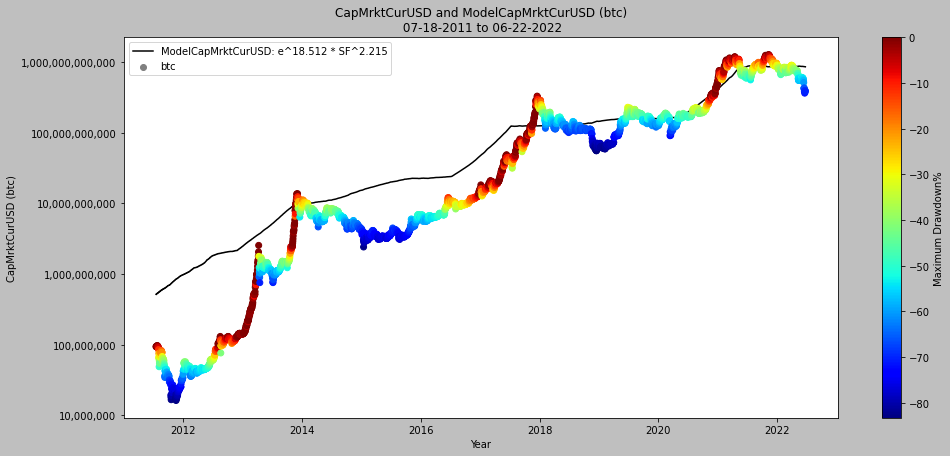

In [5]:
sf.charts(df, ticker, params_sf, chart=1, figsize=(16, 7))

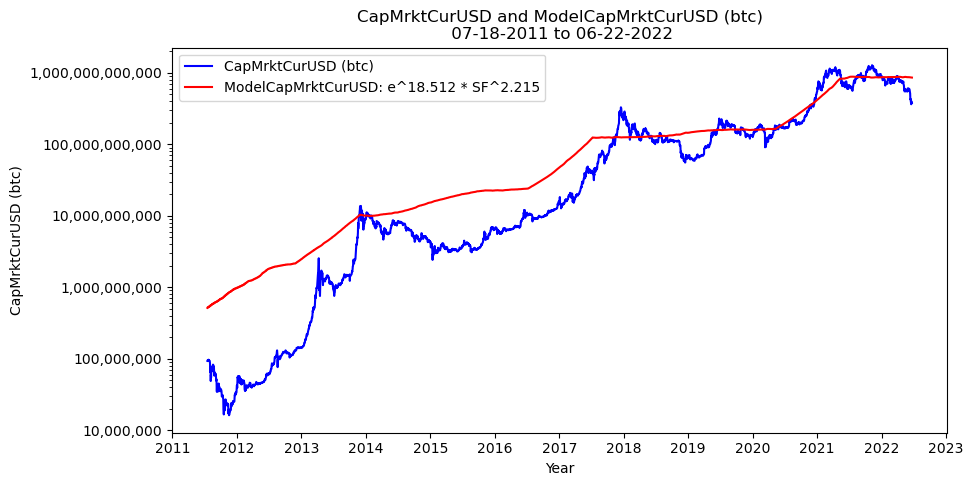

In [6]:
sf.charts(df, ticker, params_sf, chart=2, figsize=(10, 5))

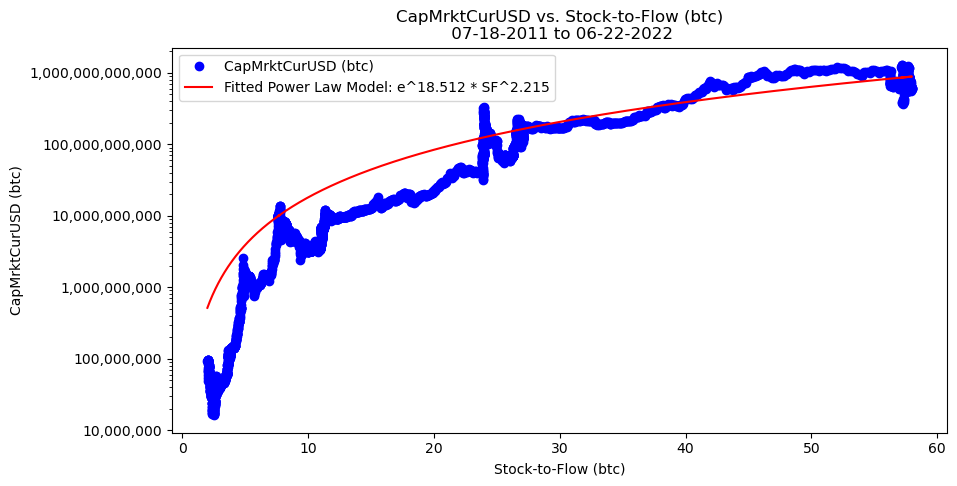

In [7]:
sf.charts(df, ticker, params_sf, chart=3, figsize=(10, 5))

## Hypothesis Test

Does the fitted power law model have statistical significance and may it possibly have explanatory value in explaining PriceUSD as a power law function of stock-to-flow? 

$H_0: \beta_1 = 0$, regression model is not statistically significant. <br>
$H_a: \beta_1 \neq 0$, regression model is statistically significant. <br>

The following robust regression analysis adjusts standard errors to account for heteroskedasticity and autocorrelation via the Newey-West method. The condition number and presence of multicollinearity can  be ignored since there is only one independent variable. 

In [8]:
results = sf.regression_analysis(df, show=True)

                            OLS Regression Results                            
Dep. Variable:          CapMrktCurUSD   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     3916.
Date:                Thu, 23 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:00:27   Log-Likelihood:            -1.0648e+05
No. Observations:                3993   AIC:                         2.130e+05
Df Residuals:                    3991   BIC:                         2.130e+05
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.012e+10   1.23

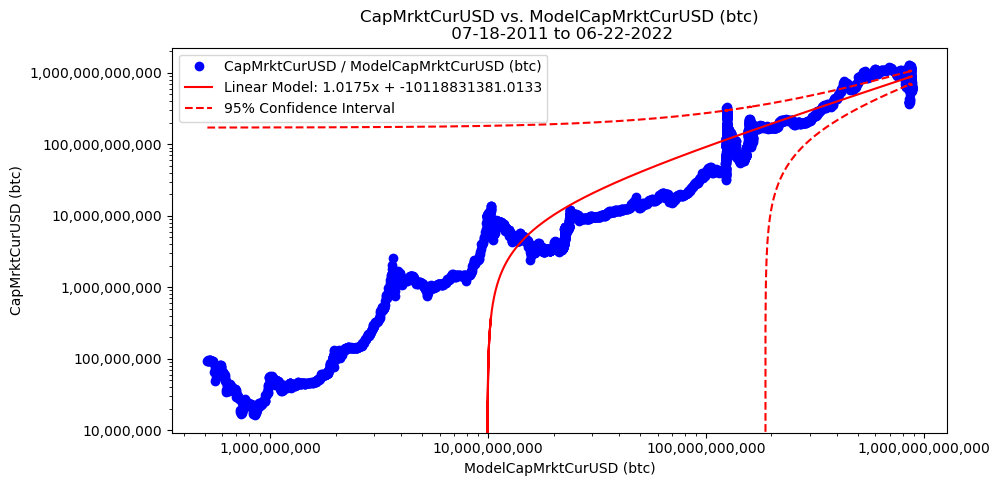

In [9]:
sf.conf_int_chart(df, ticker, results, figsize=(10, 5))

## Power Law Model Estimate

This estimate is computed based purely on the mathematical curve of the computed Power Law function. 

In [10]:
obs_ci_lower, obs_ci_upper = sf.confidence_interval(df, ticker, results, show=True)

Ticker: btc
Confidence Level: 95%
Current Market Value: $381,546,027,327.44
Lower 95%: $678,644,680,665.76 or 77.87%
Mean Estimate: $861,190,492,779.40 or 125.71%
Upper 95%: $1,043,736,304,893.03 or 173.55%


# Tests of Linear Regression Assumptions

The regression analysis rejected the null hypothesis of no correlation between price and stock-to-flow, seemingly indicating, that at the very least, stock-to-flow may be an important indicator in explaining the price of bitcoin. However, it could be a case of spurious correlation, where a correlation was found between two variables where none actually exists. In the interest of objectivety, we must examine the regression model's statistical assumptions, identify violations in these assumptions, and correct for them. It may also be the case that no corrections can be made that would make the regression model reliable. To be able to draw valid conclusions from a linear regression model with a single independent variable, we need to make the following six assumptions, known as the classic normal linear regression model assumptions: 

1. A linear relation exists between the dependent variable and the independent variables. 
2. The independent variables are not random. 
3. The expected value of the error term, conditioned on the independent variables, is 0. 
4. The variance of the error term is the same (homoskedastic) for all observations. 
5. The error term is uncorrelated across observations. 
6. The error term is normally distributed. 

Assumption 1 is critical for a valid linear regression. If the relationship between the independent and dependent variables is nonlinear in the parameters, then estimating that relation with a linear regression model will produce invalid results. For example, $Y_{i} = b_{0}e^{b_{1}X_{i}} + \epsilon_{i}$ is nonlinear in $b_{1}$, so we could not apply the linear regression model to it. However, even if the dependent variable is nonlinear, linear regression can be used as long as the regression is linear in the parameters. So, for example, linear regression can be used to estimate the equation $Y_{i} = b_{0} + b_{1}X^{2}_{i} + \epsilon_{i}$. Assumptions 2 and 3 ensure that linear regression produces the correct estimates of $b_{0}$ and $b_{1}$. Assumptions 4, 5, and 6 let us use the linear regression model to determine the distribution of the estimated parameters $\hat{b_{0}}$ and $\hat{b_{1}}$ and thus test whether those coefficients have a particular value. 

## Model Specification and Errors in Specification

The model used to estimate Bitcoin price based on stock-to-flow took the form of a Power Law function fitted to observed data. 

$MarketCapUSD = e^{a} * SF^b$ which is equivalent to $ln(MarketCapUSD) = b * ln(SF) + a$ which is a linear function. 

Both the independent and dependent variables have been transformed into their natural logarithm to account for their non-linearity. 

In [11]:
sf.markdown_model(params_sf)

Power Law Model:


<IPython.core.display.Math object>

which is equivalent to the linear function:


<IPython.core.display.Math object>

which is a linear function.


### Principles of Model Specification

Model specification refers to the set of variables included in the regression and the regression equation's functional form. The principles of model specification include the following:

1. The model should be grounded in cogent economic reasoning. 
2. The functional form chosen for the variables in the regression should be appropriate given the nature of the variables. 
3. The model should be parsimonious. We should expect each variable included in a regression to play an essential role. 
4. The model should be examined for violations of regression assumptions before being accepted. 
5. The model should be tested and be found useful out of sample before being accepted. 

### Model Mispecification

Incorrectly specifying a model can invalidate statistical inference using OLS and cause the estimated regression coefficients to be inconsistent. Three types of model mispecification include: 

1. Misspecified functional form
2. Regressors that are correlated with the error term. 
3. Additional time-series misspecification. 

#### Misspecified Functional Form

Whenever we estimate a regression, we must assme that the regression has the correct functional form. This assumption can fail in several ways: 

1. One or more important variables could be omitted from regression. 
2. One or more of the regression variables may need to be transformed (for example, by taking the natural logarithm of the variable) before estimating the regression. 
3. The regression model pools data from different samples that should not be pooled. 

## Formal Tests of Regression Assumptions

### Testing for Heteroskedasticity

We can test for a violation of the 4th assumption using the Breusch-Pagan Lagrange Multiplier test for heteroskedasticity. If a regression shows significant conditional heteroskedasticity, the standard errors and test statistics computed by regression programs will be incorrect unless they are adjusted for heteroskedasticity. One simple test for conditional heteroskedasticity is the Breusch-Pagan test. Breusch and Pagan showed that, under the null hypothesis of no conditional heteroskedasticity, $nR^2$ (from the regression of the squared residuals on the independent variables from the original regression) will be a $\chi^2$ random variable with the number of degrees of freedom equal to the number of independent variables in the regression. 

In [12]:
sf.breuschpagan(results)

Breusch-Pagan f p-value = 2.1400855780478435e-290

Conclusion: 
[1] Heteroskedasticity detected. Reject null hypothesis of no heteroskedasticity.
[2] The variance of the error terms may not be the same for all observations.
[3] OLS standard errors in this regression likely significantly underestimate the true standard errors.
[4] t-statistics for the significance of individual regression coefficients likely to be inflated and unreliable.
[5] Estimators of the standard error of regression coefficients likely to be biased and unreliable.


### Testing for Normality

In [13]:
sf.shapiro_test(results)

ShapiroResult(statistic=0.6765458583831787, pvalue=0.0)

Conclusion:
[1] Non-normality detected. Reject null hypothesis that the residuals are normal.
[2] Regression model may violate assumption of normality in linear regression.


### Testing for Serial Correlation

We can test for a violation of the 5th assumption using the Durbin-Watson test for serial correlation. The principle effect of serial correlation in a linear regression is that the standard errors and test statistics computed by regression programs will be incorrect unless adjusted for serial correlation. Positive serial correlation typically inflates the <i>t</i>-statistics of estimated regression coefficients as well as the <i>F</i>-statistic for the overall significance of the regression. The most commonly used test for serial correlation is based on the Durbin-Watson statistic. If the Durbin-Watson statistic differs sufficiently from 2, then the regression errors have significant serial correlation. 

In [14]:
sf.durbinwatson(results)

Durbin-Watson = 0.018

Conclusion: 
[1] Positive serial correlation detected. Reject null hypothesis of no positive serial correlation.
[2] F-statistic to test overall significance of the regression likely to be inflated.
[3] OLS standard errors in this regression likely significantly underestimate the true standard errors.
[4] t-statistics for the significance of individual regression coefficients likely to be inflated and unreliable.
[5] Estimators of the standard error of regression coefficients likely to be biased and unreliable.


### Testing for Covariance Stationarity

#### Dickey-Fuller Test

The Augmented Dickey-Fuller test can be used to test for a unit root in the univariate process in the presence of serial correlation. Does the time series have a unit root and is nonstationary? 

$H_0: g_1 = 0$, time series has a unit root and is nonstationary.<br>
$H_a: g_1 < 0$, no unit root detected in timeseries and is stationary.

If we fail to reject the null hypothesis, then the time series may have a unit root, indicating nonstationary variance which is a violation of the classic normal linear regression model assumptions. 

In [15]:
sf.adfuller_test(df)

Augmented Dickey-Fuller = 0.9395 (StocktoFlow)
Augmented Dickey-Fuller = 0.4149 (CapMrktCurUSD)

Conclusion: 
[1] Unit root and nonstationarity detected in both time series. Reject null hypothesis of no unit root and stationarity.
[2] Expected value of the error term may not be 0 which may result in inconsistent regression coefficients and standard erros.
[3] Variance of the error term may not be constant for all observations indicating presence of heteroskedasticity.
[4] Error term may be correlated across observations indicating presence of serial correlation.
[5] Regression model appears to violate nonstationarity assumption of linear regression and may need to be corrected.


### Testing for Cointegration

Cointegration is a requirement for valid linear regression model. We can use the augmented Engle-Granger two-step cointegration to test the hypothesis of no cointegration. 

$H_0: p >= 0.05$, no cointegration detected between time series.<br>
$H_a: p < 0.05$, cointegration detected between time series. 

If we fail to reject to reject the null hypothesis, no cointegration was detected, meaning linear regression of one variable on the other may be meaningless due to covariance nonstationarity. 

In [16]:
sf.cointegration(df)

Cointegration p-value = 0.189

Conclusion: 
[1] No cointegration detected at the 5% level. Fail to reject null hypothesis.
[2] There may not exist a cointegrated relationship between the dependent and independent variables.
[3] Regression model is likely to show spurious correlation and be unreliable.


# Plan B's Stock-to-Flow Model

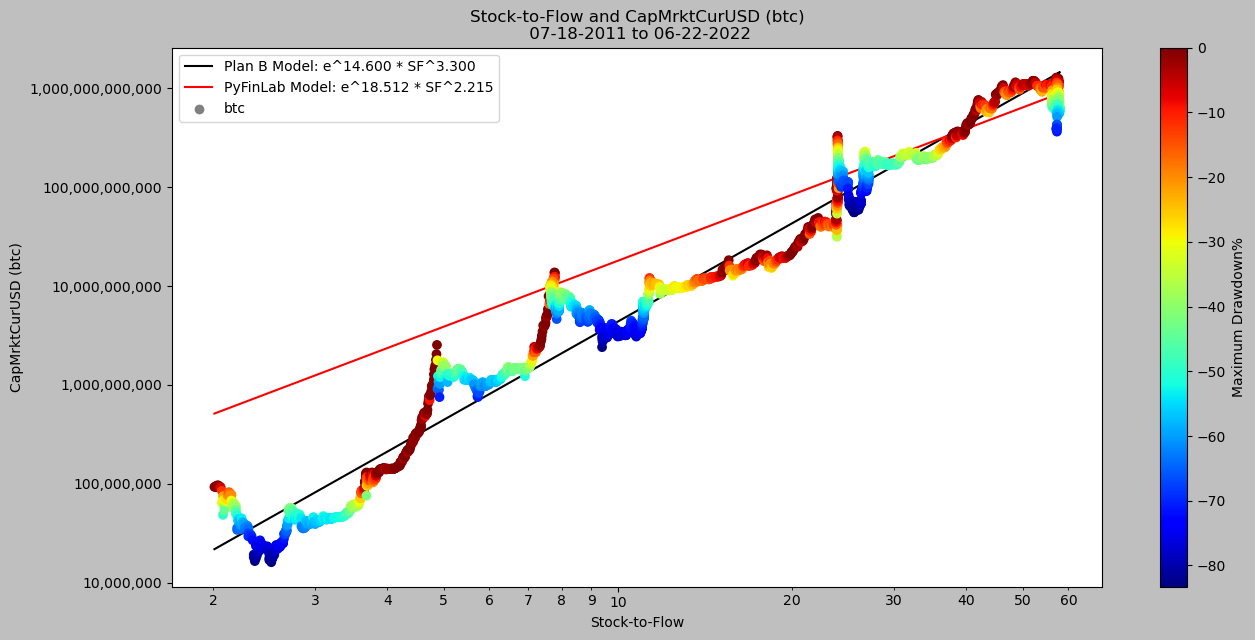

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style, cm
from matplotlib.ticker import FuncFormatter, ScalarFormatter
a1, b1 = 14.6, 3.3
a2, b2 = params_sf[0], params_sf[1]
sf = df['StocktoFlow'].to_numpy()
drawdown = (df['MaxDrawdown%'] * 100).to_numpy()
ytrue = df['CapMrktCurUSD'].to_numpy()
ypred_planb, ypred_pyfinlab = np.exp(a1) * sf**b1, np.exp(a2) * sf**b2
plt.style.use('grayscale')
fig, ax = plt.subplots(figsize=(15,7))
im = ax.scatter(sf, ytrue, c=drawdown, cmap=cm.jet, lw=1, alpha=1, zorder=5, label=ticker)
plt.xscale('log')
plt.yscale('log', subsy=[1])
ax.plot(sf, ypred_planb, c='black', label='Plan B Model: e^{:.3f} * SF^{:.3f}'.format(a1, b1))
ax.plot(sf, ypred_pyfinlab, c='red', label='PyFinLab Model: e^{:.3f} * SF^{:.3f}'.format(a2, b2))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_minor_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(FuncFormatter(lambda ytrue, _: '{:,.16g}'.format(ytrue)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda sf, _: '{:,.16g}'.format(sf)))
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Maximum Drawdown%')
plt.xlabel('Stock-to-Flow')
plt.ylabel('CapMrktCurUSD ({})'.format(ticker))
plt.title("Stock-to-Flow and CapMrktCurUSD ({})\n {} to {}".format(
    ticker,
    df.index[0].strftime('%m-%d-%Y'),
    df.index[-1].strftime('%m-%d-%Y')))
plt.legend()
plt.show();

In [19]:
df['ModelPriceUSD'] = df['ModelCapMrktCurUSD'] / df['SplyCur']

In [20]:
df

,CapMrktCurUSD,PriceUSD,BlkCntMonthly,BlkCnt,TotalBlks,SplyCur,StocktoFlow,ModelCapMrktCurUSD,Difference%,MaxDrawdown%,ModelPriceUSD
time,,,,,,,,,,,
2011-07-18,9.334931e+07,13.63,NaN,170.0,68189.0,6848549.99,2.01,5.145321e+08,4.511901,0.0000,75.130085
2011-07-19,9.477795e+07,13.82,NaN,142.0,68331.0,6855649.99,2.02,5.202206e+08,4.488835,0.0000,75.882024
2011-07-20,9.387575e+07,13.68,NaN,149.0,68480.0,6863099.99,2.02,5.202206e+08,4.541587,-0.0095,75.799653
2011-07-21,9.352265e+07,13.61,NaN,152.0,68632.0,6870699.99,2.02,5.202206e+08,4.562509,-0.0132,75.715807
2011-07-22,9.422203e+07,13.70,NaN,151.0,68783.0,6878249.99,2.03,5.259434e+08,4.581957,-0.0059,76.464709
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-18,3.626112e+11,19013.87,4265.0,156.0,672590.0,19070879.68,57.31,8.609946e+11,1.374429,-0.7155,45147.084858
2022-06-19,3.908231e+11,20492.30,4270.0,133.0,672723.0,19071710.93,57.28,8.599964e+11,1.200475,-0.6933,45092.777581
2022-06-20,3.923531e+11,20571.63,4267.0,132.0,672855.0,19072535.93,57.25,8.589989e+11,1.189351,-0.6921,45038.523104


In [23]:
print('Current Model Price: {}'.format('${:,.2f}'.format(df['ModelPriceUSD'].iloc[-1])))

Current Model Price: $44,895.10
